In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
import praw
import re
import spacy
import os
import json
import praw
import time
import pyLDAvis
from textblob import TextBlob
from dotenv import load_dotenv
from requests.exceptions import RequestException
from scipy.stats import ttest_1samp
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

## 1. Data Collection

In [2]:
load_dotenv(override=True) 
reddit = praw.Reddit(
    client_id = os.getenv('CLIENT_ID'),
    client_secret = os.getenv('CLIENT_SECRET'),
    user_agent = os.getenv('USER_AGENT')
)

In [3]:
stored_posts_dict = {}
print(f"Current posts stored: {len(stored_posts_dict)}")

Current posts stored: 0


In [4]:
def fetch_posts(subreddit_name, query, retries=7, delay=5):
    posts = []
    subreddit = reddit.subreddit(subreddit_name)
    for attempt in range(retries):
        try:
            search_query = f"{query}"
            print(f"Searching r/{subreddit_name} for '{query}'")
            for post in subreddit.search(query, limit = 100):
                if post.url not in stored_posts_dict and post.url.startswith('https://www.reddit.com'):
                    post_data = ({
                        'title': post.title,
                        'content': post.selftext,
                        'url': post.url,
                        'created_utc': dt.fromtimestamp(post.created_utc).strftime('%Y-%m-%d %H:%M:%S'),
                        'subreddit': post.subreddit.display_name
                    })
                    stored_posts_dict[post.url] = post_data
                    posts.append(post_data)
        except RequestException as e:
            print(f"Request failed: {e}. Retrying in {delay} second...")
            time.sleep(delay)
            delay *=2
    return posts


def save_posts_csv(csv_path):
    df = pd.DataFrame(stored_posts_dict.values())
    df.to_csv(csv_path, index=False)
    print(f"CSV updated with {len(stored_posts_dict)} total posts.")
    return df


In [5]:
queries = ['opioid','heroin','fentanyl','cocaine','meth','amphetamine','oxy','painkiller']
subreddits = ['opiates', 'Drugs', 'addiction', 'Stims', 'redditorsinrecovery', 'AskReddit', 'unpopularopinion', 'confessions', 'NoStupidQuestions', 'Leaves', 'TrueOffMyChest', 'selfmedicating']
dict_count = len(stored_posts_dict)
for subreddit_name in subreddits:
        for query in queries:
                posts = fetch_posts(subreddit_name, query)
dict_count_new = len(stored_posts_dict)
print(f"New posts added to dictionary: {dict_count_new-dict_count} (Total: {dict_count_new})")

Searching r/opiates for 'opioid'
Searching r/opiates for 'opioid'
Searching r/opiates for 'opioid'
Searching r/opiates for 'opioid'
Searching r/opiates for 'opioid'
Searching r/opiates for 'opioid'
Searching r/opiates for 'opioid'
Searching r/opiates for 'heroin'
Searching r/opiates for 'heroin'
Searching r/opiates for 'heroin'
Searching r/opiates for 'heroin'
Searching r/opiates for 'heroin'
Searching r/opiates for 'heroin'
Searching r/opiates for 'heroin'
Searching r/opiates for 'fentanyl'
Searching r/opiates for 'fentanyl'
Searching r/opiates for 'fentanyl'
Searching r/opiates for 'fentanyl'
Searching r/opiates for 'fentanyl'
Searching r/opiates for 'fentanyl'
Searching r/opiates for 'fentanyl'
Searching r/opiates for 'cocaine'
Searching r/opiates for 'cocaine'
Searching r/opiates for 'cocaine'
Searching r/opiates for 'cocaine'
Searching r/opiates for 'cocaine'
Searching r/opiates for 'cocaine'
Searching r/opiates for 'cocaine'
Searching r/opiates for 'meth'
Searching r/opiates for 

## 2. Data Preprocessing

In [6]:
df = save_posts_csv(csv_path = './data/reddit_posts.csv')
nlp = spacy.load("en_core_web_sm")

data = df
data['content'] = data['content'].fillna('')
data= data[data['content'].str.strip() != '']
data.loc[:, 'content'] = data['content'].apply(lambda text: ' '.join(
    [token.lemma_ for token in nlp(re.sub(r'http\S+|[^a-zA-Z ]','',text.lower()))
     if not token.is_stop and len(token.text)>2]
))
data.to_csv('./data/reddit_posts_processed.csv', index=False)


CSV updated with 3351 total posts.


## 3. Sentiment Analysis
### 3.1. Sentiment Polarity

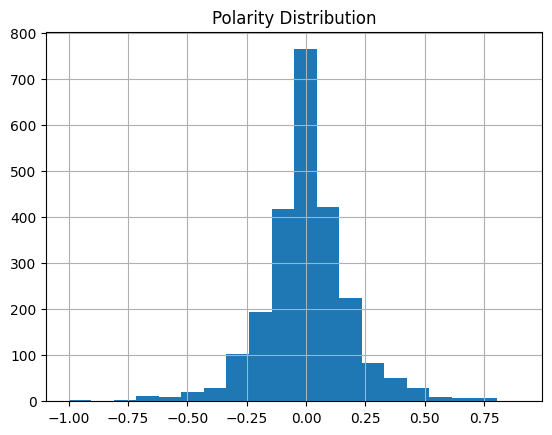

(T-test for sentiment polarity) T-stat: 0.7584207372898364, P-value: 0.4482741160169713


In [8]:
def sentiment_analysis(df):
    df.loc[:, 'sentiment_polarity'] = df['content'].apply(lambda text: TextBlob(text).sentiment.polarity)
    df.loc[:, 'sentiment_subjectivity'] = df['content'].apply(lambda text: TextBlob(text).sentiment.subjectivity)
    return df

data = data.copy()

sentiment_analysis(data)

data['sentiment_polarity'].hist(bins=20)
plt.title('Polarity Distribution')
plt.show()

t_stat, p_value = ttest_1samp(data['sentiment_polarity'],0)
print(f"(T-test for sentiment polarity) T-stat: {t_stat}, P-value: {p_value}")

The **polarity distribution** is bell shaped, centered around 0, indicating that most posts have sentiment polarities near neutral.

A **t-test** was conducted to determine if the average sentiment polarity is significantly different from zero.
- **The T-statistic**  measures the deviation of the mean sentiment polarity from 0
- **The P-value** is greater than 0.05, indicating that the deviation from neutrality is not statistically significant. 

### 3.2 Sentiment Subjectivity

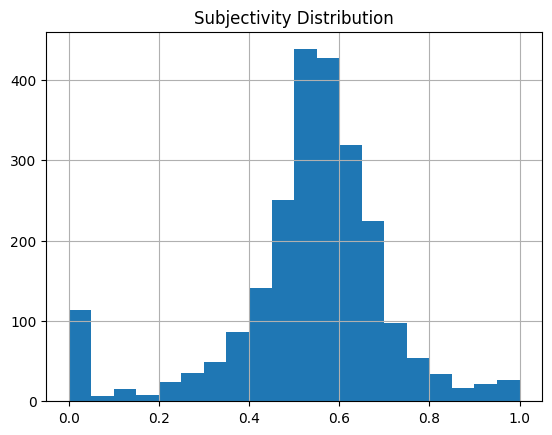

(T-test for sentiment subjectivity) T-stat: 144.97573986890004, P-value: 0.0


In [47]:
data['sentiment_subjectivity'].hist(bins=20)
plt.title('Subjectivity Distribution')
plt.show()

t_stat, p_value = ttest_1samp(data['sentiment_subjectivity'],0)
print(f"(T-test for sentiment subjectivity) T-stat: {t_stat}, P-value: {p_value}")

The **subjectivity distribution** is bimodal, with a large peak around `0.5 - 0.6`, indicating that many posts are moderately subjective. There is also a smaller peak at 0.0, suggesting that a number of posts are objective. 

The **t-test** result is highly statistically significant, suggesting that the majority of posts are subjective rather than purely objective. 
- **T-statistic** is extremely high, suggesting a strong deviation from the null hypothesis (which assumes subjectivity is centered around 0)
- **P-value** is effectively zero, strongly suggesting that the mean subjectivity is significantly greater than zero

## 4. Topic Modeling

In [14]:
def topic_modeling(df): 
    stop_words = list(ENGLISH_STOP_WORDS) + ['like', 'want', 'know', 'thing', 'say', 'tell', 'talk', 'feel', 'make', 'look', 'really', 'think', 'come', 'day', 'week', 'year', 'watch']
    vec = CountVectorizer(max_df=.95, min_df=2, stop_words=stop_words)
    dtm = vec.fit_transform(df['content'])
    lda_model = LatentDirichletAllocation(n_components = 3, random_state=42)
    lda_model.fit(dtm)
    print(f"Topic Modeling Complete.")
    return lda_model, dtm, vec

def display_topics(lda_model, vectorizer, n_words=10):
    feature_names = vectorizer.get_feature_names_out()
    for idx, topic in enumerate(lda_model.components_):
        print(f"\nTopic {idx+1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[-n_words:]]))

lda_model, dtm, vec = topic_modeling(data)
display_topics(lda_model, vec)

Topic Modeling Complete.

Topic 1:
month bad good mom work try start life friend time

Topic 2:
prescribe use cause bad need medication pain doctor drug people

Topic 3:
work fentanyl life use heroin pain addict time people drug


In [15]:
# Categorize posts by topic
def extract_posts_by_topic(df, lda_model, vectorizer):
    dtm = vectorizer.transform(df['content'])
    topic_distribution = lda_model.transform(dtm)
    df['topic'] = topic_distribution.argmax(axis=1)
    for topic_num in range(lda_model.n_components):
        topic_df = df[df['topic'] == topic_num]
        csv_path = f'./data/topic_{topic_num+1}_posts.csv'
        topic_df.to_csv(csv_path, index=False)
        print(f"Saved Topic {topic_num+1} posts to {csv_path}")

extract_posts_by_topic(data, lda_model, vec)

Saved Topic 1 posts to ./data/topic_1_posts.csv
Saved Topic 2 posts to ./data/topic_2_posts.csv
Saved Topic 3 posts to ./data/topic_3_posts.csv


In [16]:
import pyLDAvis.lda_model

vis = pyLDAvis.lda_model.prepare(lda_model, dtm, vec)
pyLDAvis.save_html(vis, './data/topic_visualization.html')
pyLDAvis.display(vis)

Here is a preliminary anlysis of the keywords and categorized posts from each topic:
### Topic 1: General Life and Family Dynamics
This topic appears to revolve around personal life experiences, relationship and family matters. It can provide context on how substance use may intersect with life events, social environments, and family challenges. 
### Topic 2: Medical and Prescription Drug Use
This topic seems to focus heavily on medical and prescription drug use, specifically discussing pain management, doctor prescriptions, and potential medical dependency. It can provide context on the transition from medical opioid use to potential misuse or addiction. 
### Topic 3: Addiction and Substance Use Disorders
This topic seems to highlight fentanyl and heroin addiction, emphasizing severe substance abuse and addiction. It focuses on late-stage addiction, overdose, struggles of dealing with substance use disorders, and impacts of addiction and drug dependency.


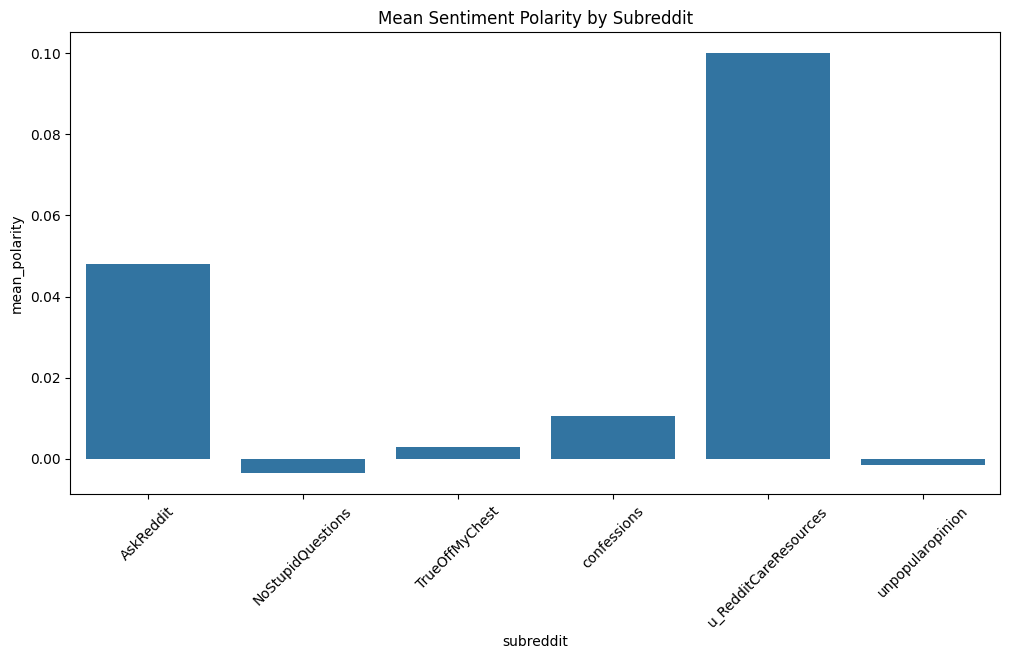

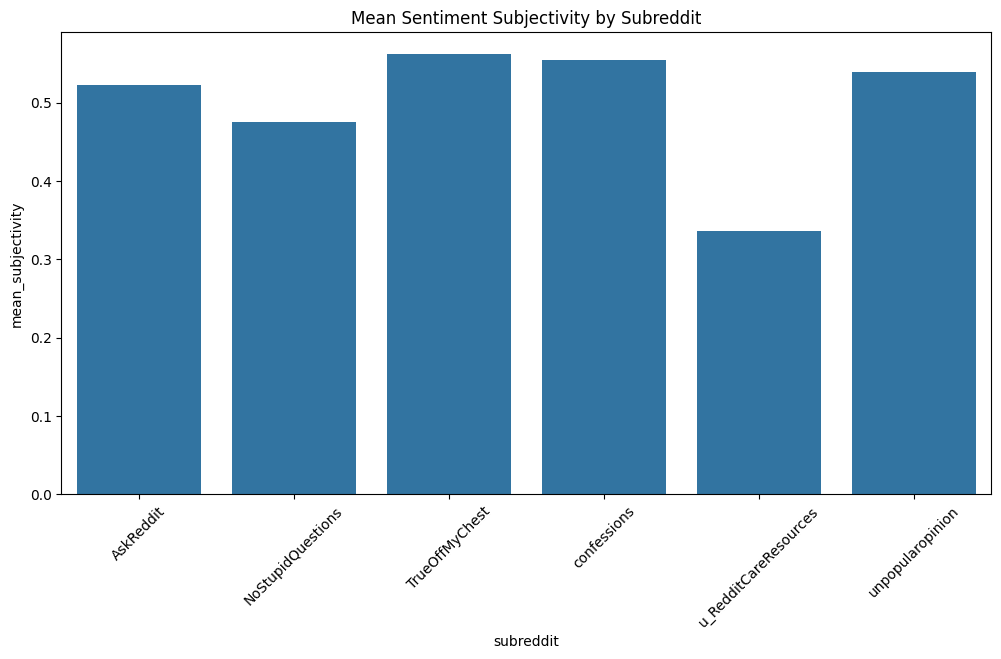

Spearman Correlation between Subreddit Post Count and Mean Polarity: -0.77, P-value: 0.0724
ANOVA Result (Sentiment Polarity Across Subreddits):    mean_polarity
0            0.0
1            1.0
Subreddits with Significant Sentiment Polarity (>|0.1|):
Empty DataFrame
Columns: [subreddit, mean_polarity, mean_subjectivity, post_count]
Index: []


In [ ]:
from scipy.stats import spearmanr, ttest_ind

# Group by Subreddit and Calculate Mean Sentiment
subreddit_sentiment = data.groupby('subreddit').agg(
    mean_polarity=('sentiment_polarity', 'mean'),
    mean_subjectivity=('sentiment_subjectivity', 'mean'),
    post_count=('subreddit', 'size')
).reset_index()

# Plot Mean Sentiment by Subreddit
plt.figure(figsize=(12, 6))
sns.barplot(x='subreddit', y='mean_polarity', data=subreddit_sentiment)
plt.xticks(rotation=45)
plt.title('Mean Sentiment Polarity by Subreddit')
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x='subreddit', y='mean_subjectivity', data=subreddit_sentiment)
plt.xticks(rotation=45)
plt.title('Mean Sentiment Subjectivity by Subreddit')
plt.show()


In [38]:
# Step 3: Correlation Analysis
correlation, p_value = spearmanr(subreddit_sentiment['mean_polarity'], subreddit_sentiment['post_count'])
print(f"Spearman Correlation between Subreddit Post Count and Mean Polarity: {correlation:.2f}, P-value: {p_value:.4f}")

# Step 4: Test for Sentiment Differences Across Subreddits (ANOVA)
anova_result = subreddit_sentiment[['mean_polarity']].apply(lambda x: ttest_ind(x, subreddit_sentiment['mean_polarity']))
print(f"ANOVA Result (Sentiment Polarity Across Subreddits): {anova_result}")

# Step 5: Filter for Significant Correlations
significant_subreddits = subreddit_sentiment[subreddit_sentiment['mean_polarity'].abs() > 0.1]
print(f"Subreddits with Significant Sentiment Polarity (>|0.1|):")
print(significant_subreddits)

Spearman Correlation between Subreddit Post Count and Mean Polarity: -0.77, P-value: 0.0724
ANOVA Result (Sentiment Polarity Across Subreddits):    mean_polarity
0            0.0
1            1.0
Subreddits with Significant Sentiment Polarity (>|0.1|):
Empty DataFrame
Columns: [subreddit, mean_polarity, mean_subjectivity, post_count]
Index: []


In [ ]:
"""
def topic_modeling(df):
    stop_words = list(ENGLISH_STOP_WORDS) + ['like', 'want', 'know', 'thing', 'say', 'tell', 'talk', 'feel', 'make', 'look', 'really', 'think', 'come', 'day', 'week', 'year', 'watch']
    vec = CountVectorizer(max_df=.95, min_df=2, stop_words=stop_words)
    dtm = vec.fit_transform(df['content'])

    grid = {
        'n_components': [3,4,5,6,7,8],
        'random_state': [42]
    }
    lda_model = LatentDirichletAllocation(max_iter=10, learning_method='online', random_state=42)
    grid_search = GridSearchCV(
        estimator=lda_model,
        param_grid=grid,
        scoring='neg_log_loss',
        cv=5,
        verbose=2
    )
    grid_search.fit(dtm)
    best_lda_model = grid_search.best_estimator_
    best_n_topics = best_lda_model.n_components 
    print(f"Best n_topics: {best_n_topics}")

    return best_lda_model, dtm, vec

def display_topics(lda_model, vectorizer, n_words=10):
    feature_names = vectorizer.get_feature_names_out()
    for idx, topic in enumerate(lda_model.components_):
        print(f"\nTopic {idx+1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[-n_words:]]))

lda_model, dtm, vec = topic_modeling(data)
display_topics(lda_model, vec)
"""